In [2]:
import pandas as pd
import numpy as np
import joblib
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense

In [3]:
bitcoin_df = pd.read_csv('Bitcoin_Data.csv')
bitcoin_df = bitcoin_df.drop("Adj Close", axis=1)
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])
float_cols = bitcoin_df.drop(columns='Date').columns.tolist()
for col in float_cols:
    bitcoin_df[col] = bitcoin_df[col].str.replace(',', '').astype(float)
bitcoin_df = bitcoin_df.sort_values('Date').reset_index(drop=True)
bitcoin_df["Log Volume"] = np.log1p(bitcoin_df['Volume'])
bitcoin_df

,Date,Open,High,Low,Close,Volume,Log Volume
0,2019-10-18,8100.93,8138.41,7902.16,7973.21,1.565159e+10,23.473839
1,2019-10-19,7973.80,8082.63,7944.78,7988.56,1.379783e+10,23.347777
2,2019-10-20,7997.81,8281.82,7949.44,8222.08,1.550425e+10,23.464380
3,2019-10-21,8225.12,8296.69,8196.42,8243.72,1.586875e+10,23.487618
4,2019-10-22,8243.40,8296.65,8074.46,8078.20,1.680338e+10,23.544846
...,...,...,...,...,...,...,...
1787,2024-09-08,54147.93,55300.86,53653.76,54841.57,1.826829e+10,23.628432
1788,2024-09-09,54851.89,58041.13,54598.43,57019.54,3.461810e+10,24.267642
1789,2024-09-10,57020.10,58029.98,56419.41,57648.71,2.885763e+10,24.085640
1790,2024-09-11,57650.29,57991.32,55567.34,57343.17,3.704906e+10,24.335509


In [4]:
X = bitcoin_df[['Open', 'High', 'Low', 'Log Volume']]
y = bitcoin_df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

importances = rf.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.5f}")

Open: 0.03336
High: 0.81659
Low: 0.14983
Log Volume: 0.00022


In [5]:
X_HiLo = bitcoin_df[['High', 'Low']]
X_HiLo_train, X_HiLo_test, y_HiLo_train, y_HiLo_test = train_test_split(X_HiLo, y, test_size=0.3, random_state=42)

In [6]:
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)
X_HiLo_train_scaled = standard_scaler.fit_transform(X_HiLo_train)
X_HiLo_test_scaled = standard_scaler.transform(X_HiLo_test)

In [7]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_Hilo = LinearRegression()
lr_Hilo.fit(X_HiLo_train_scaled, y_HiLo_train)

LinearRegression()

In [8]:
coefs = lr.coef_
ftr_imp = pd.DataFrame(coefs, index=X.columns, columns=["Coefficient"])
print(ftr_imp)

coefs_Hilo = lr_Hilo.coef_
ftr_imp_HiLo = pd.DataFrame(coefs_Hilo, index=X_HiLo.columns, columns=["Coefficient"])
print(ftr_imp_HiLo)

             Coefficient
Open       -10374.780414
High        17156.565741
Low         11745.862715
Log Volume    -17.150999
       Coefficient
High  10211.889600
Low    8316.165751


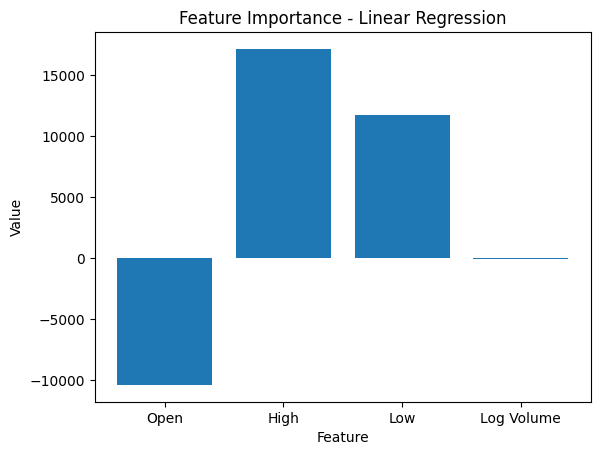

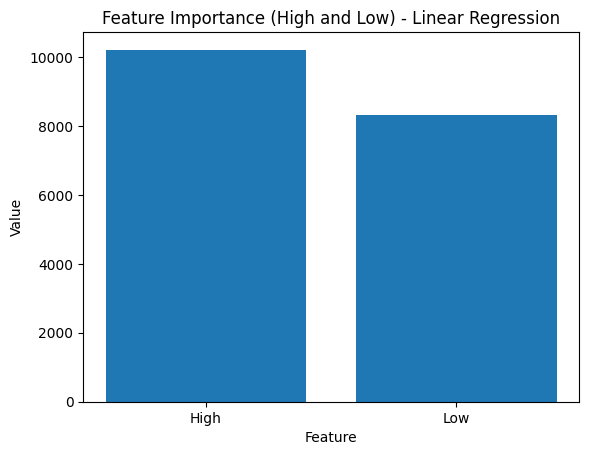

In [9]:
plt.bar(ftr_imp.index, ftr_imp['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Feature Importance - Linear Regression')
plt.show()

plt.bar(ftr_imp_HiLo.index, ftr_imp_HiLo['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Feature Importance (High and Low) - Linear Regression')
plt.show()

In [10]:
y_pred = lr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R^2 Score: {r2}")

y_HiLo_pred = lr_Hilo.predict(X_HiLo_test_scaled)
mse_HiLo = mean_squared_error(y_HiLo_test, y_HiLo_pred)
mae_HiLo = mean_absolute_error(y_HiLo_test, y_HiLo_pred)
r2_HiLo = r2_score(y_HiLo_test, y_HiLo_pred)

print("\nModel Evaluation (High and Low)")
print(f"MSE: {mse_HiLo}")
print(f"MAE: {mae_HiLo}")
print(f"R^2 Score: {r2_HiLo}")

Model Evaluation
MSE: 203652.0573264711
MAE: 286.484024564324
R^2 Score: 0.999389039518301

Model Evaluation (High and Low)
MSE: 367629.5092070434
MAE: 382.02220230525995
R^2 Score: 0.9988971036925406


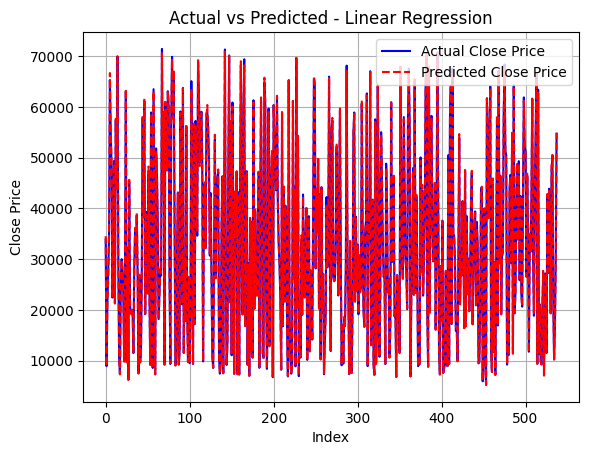

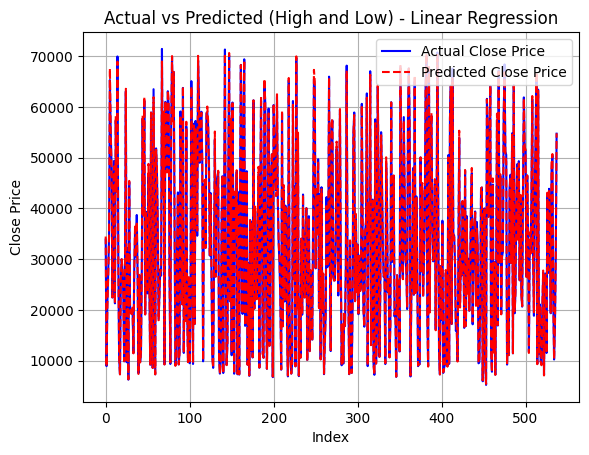

In [11]:
plt.plot(y_test.values, label='Actual Close Price', color='blue')
plt.plot(y_pred, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted - Linear Regression')
plt.legend()
plt.grid()
plt.show()

plt.plot(y_test.values, label='Actual Close Price', color='blue')
plt.plot(y_HiLo_pred, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted (High and Low) - Linear Regression')
plt.legend()
plt.grid()
plt.show()

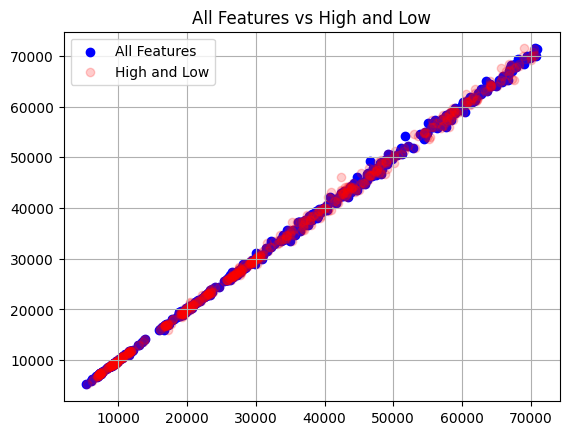

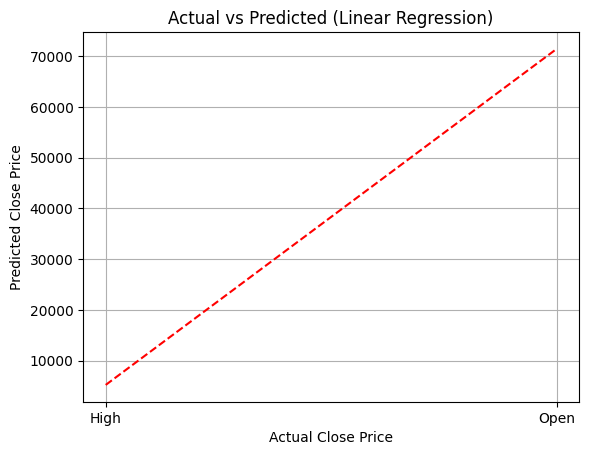

In [12]:
plt.title("All Features vs High and Low")
plt.scatter(y_pred, y_test, color='blue', label='All Features')
plt.scatter(y_HiLo_pred, y_HiLo_test, color='red', label="High and Low", alpha=0.2)
plt.legend()
plt.grid()
plt.show()

plt.plot([min(X_test), max(X_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted (Linear Regression)')
plt.grid()
plt.show()

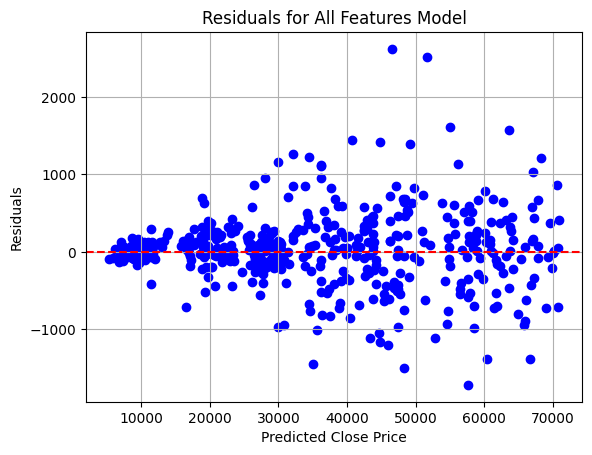

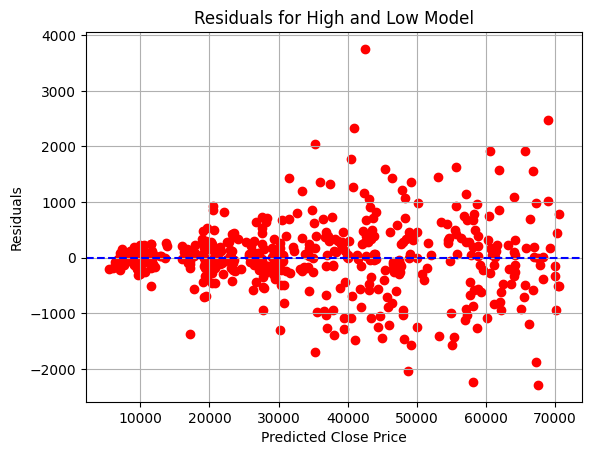

In [13]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Close Price')
plt.ylabel('Residuals')
plt.title('Residuals for All Features Model')
plt.grid()
plt.show()

residuals_hilo = y_HiLo_test - y_HiLo_pred
plt.scatter(y_HiLo_pred, residuals_hilo, color='red')
plt.axhline(y=0, color='blue', linestyle='--')
plt.xlabel('Predicted Close Price')
plt.ylabel('Residuals')
plt.title('Residuals for High and Low Model')
plt.grid()
plt.show()


In [14]:
features_scaled = standard_scaler.fit_transform(X)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)
print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
print(pca_df.head())
print(f'\nPCA Components (weights of original features):\n{pca.components_}')

Explained Variance Ratio: [0.76421223 0.23521999]
        PC1       PC2
0 -2.446459 -0.732067
1 -2.492492 -0.976294
2 -2.446950 -0.750822
3 -2.423982 -0.708530
4 -2.408309 -0.596679

PCA Components (weights of original features):
[[ 0.56935023  0.57008619  0.56795668  0.16812867]
 [-0.09429998 -0.07929303 -0.11757749  0.98539112]]


Mean Squared Error: 203652.0573264711
Mean Absolute Error: 286.484024564324
R-squared: 0.999389039518301


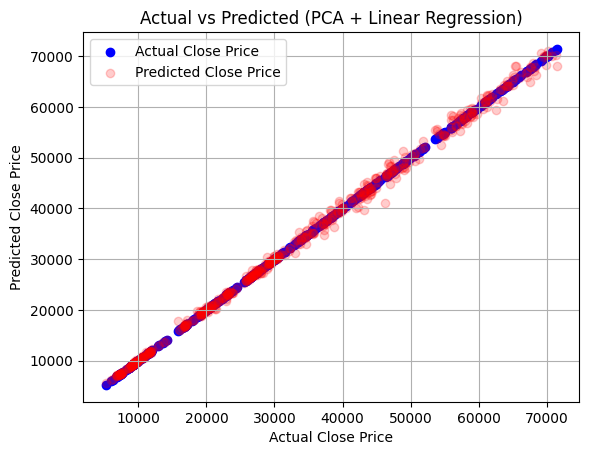

In [15]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_pca, y_train)

y_pred_pca = model.predict(X_test_pca)
mse_pca = mean_squared_error(y_test, y_pred)
mae_pca = mean_absolute_error(y_test, y_pred)
r2_pca = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse_pca}')
print(f'Mean Absolute Error: {mae_pca}')
print(f'R-squared: {r2_pca}')

plt.scatter(y_test, y_test, color='blue', label='Actual Close Price')
plt.scatter(y_test, y_pred_pca, color='red', label='Predicted Close Price', alpha=0.2)
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted (PCA + Linear Regression)')
plt.legend()
plt.grid()
plt.show()

In [16]:
X_train_scaled_dl = standard_scaler.fit_transform(X_train)
X_test_scaled_dl = standard_scaler.transform(X_test)

model = Sequential()
model.add(Dense(units=312, activation='relu', input_dim=X_train_scaled_dl.shape[1]))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.fit(X_train_scaled_dl, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=1)

y_pred_dl = model.predict(X_test_scaled_dl)
mse_dl = mean_squared_error(y_test, y_pred_dl)
mae_dl = mean_absolute_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)

print("Deep Learning Model Evaluation")
print(f"MSE: {mse_dl}")
print(f"MAE: {mae_dl}")
print(f"R^2 Score: {r2_dl}")

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1474326400.0000 - mae: 33326.8438 - val_loss: 1370947200.0000 - val_mae: 32661.3105
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1216817024.0000 - mae: 29950.4336 - val_loss: 1000055872.0000 - val_mae: 27800.5918
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 768585280.0000 - mae: 23129.5859 - val_loss: 383886400.0000 - val_mae: 17681.2676
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 250289888.0000 - mae: 14047.3857 - val_loss: 129575264.0000 - val_mae: 9946.0635
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 104077344.0000 - mae: 8910.7021 - val_loss: 84346888.0000 - val_mae: 8235.9043
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 77211336.0000 - mae: 7895.3579 - val_loss: 59653464.0000 - val_mae: 6859.2832
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 53370784.0000 - mae: 6503.8423 - val_loss: 42030708.0000 - val_mae: 5677.4033
Epoch 8

In [17]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"Best Random Forest Parameters: {grid_search.best_params_}")
print(f"MSE: {mse_best_rf}")
print(f"MAE: {mae_best_rf}")
print(f"R^2 Score: {r2_best_rf}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Random Forest Parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
MSE: 408831.2429374812
MAE: 396.7412006184999
R^2 Score: 0.9987734976194312


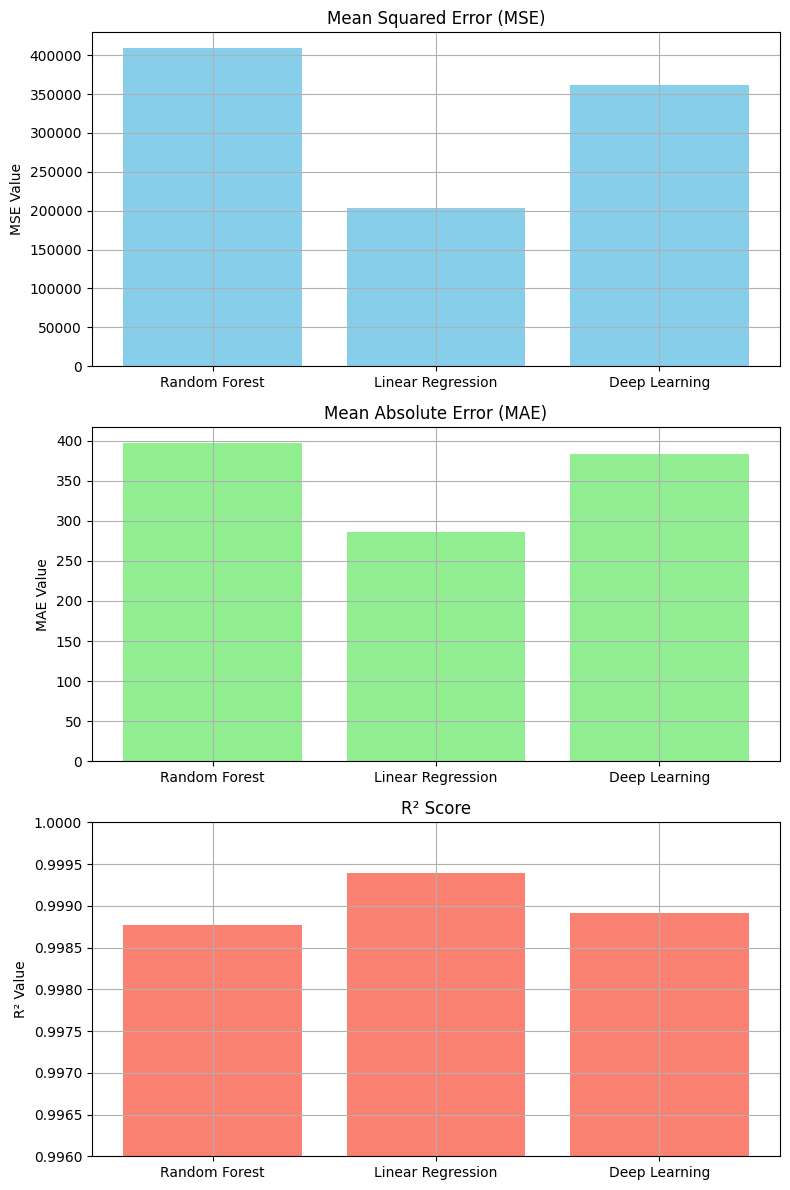

In [18]:
models = ['Random Forest', 'Linear Regression', 'Deep Learning']
mse_values = [mse_best_rf, mse, mse_dl]
mae_values = [mae_best_rf, mae, mae_dl]
r2_values = [r2_best_rf, r2, r2_dl]

x = range(len(models))
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].bar(models, mse_values, color='skyblue')
axs[0].set_title('Mean Squared Error (MSE)')
axs[0].set_ylabel('MSE Value')
axs[0].grid(True)

axs[1].bar(models, mae_values, color='lightgreen')
axs[1].set_title('Mean Absolute Error (MAE)')
axs[1].set_ylabel('MAE Value')
axs[1].grid(True)

axs[2].bar(models, r2_values, color='salmon')
axs[2].set_title('R² Score')
axs[2].set_ylabel('R² Value')
axs[2].grid(True)

axs[2].set_ylim([0.996, 1.0])
plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(best_rf, 'random_forest_model.pkl')
joblib.dump(lr, 'linear_regression_model.pkl')
joblib.dump(standard_scaler, 'scaler.pkl')
model.save('neural_network_model.keras')